## Importing the relevant packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [3]:
raw_csv_data = pd.read_csv("dataset/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [4]:
df_comp['market_value']=df_comp.ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

## The DF-Test

In [7]:
# p-value = 0.33 > 0.05, rejectm cannot say it's a random walk
sts.adfuller(df.market_value)

(-1.904155141883687,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

## Using Returns

In [12]:
# missing value will cause the time series analysis collapse, so you need to remove the first value for %
df['Returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

<ipython-input-12-72101f464e5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Returns'] = df.market_value.pct_change(1).mul(100)


In [14]:
# returns come from a stationary process
sts.adfuller(df.Returns)

(-12.770265719497221,
 7.798058336038833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

## ACF and PACF for Returns

Text(0, 0.5, 'correlation')

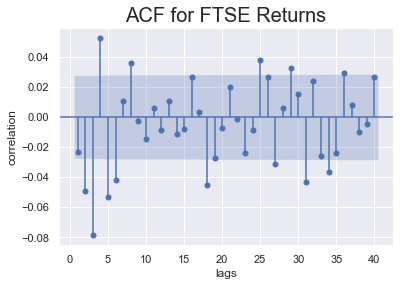

In [15]:
# look at the line that is above the blue area, that means it's significant
# most of the correlations are neagtive, we can view as some corrections in the week (cyclical changes)
sgt.plot_acf(df.Returns, zero=False, lags=40)
plt.title('ACF for FTSE Returns', size=20)
plt.xlabel('lags')
plt.ylabel('correlation')

Text(0, 0.5, 'correlation')

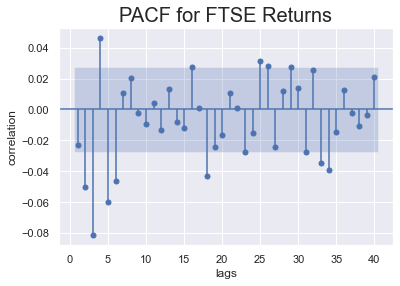

In [16]:
# it's similar to the ACF graph, can interpret as the price is usually the opposite side of the previous day's
# The negative relationship between past and current values suggests that the data wants to avoid falling in a big trend (e.g avoids clustering)
sgt.plot_pacf(df.Returns, zero=False, lags=40, alpha=0.05, method=('ols'))
plt.title('PACF for FTSE Returns', size=20)
plt.xlabel('lags')
plt.ylabel('correlation')

## AR(1) for Returns

In [17]:
model_ar = ARMA(df.Returns, order=(1,0))

In [18]:
results_ar = model_ar.fit()

In [19]:
# ALL of the P-VALUE are >0.05, no variable is significant enough
# The more easily yesterday's price is affected by higher lags, the more inaccurate its coefficient becomes
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Tue, 09 Mar 2021   AIC                          15865.497
Time:                        21:11:03   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.Returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4386           +0.0000j           43.4386            0.5000
-----------------------------------------------------------------------------
"""

## Higher-Lag AR Models for Returns

In [20]:
# beta_2 is very significant, and p-value for beta_1 decrease, maybe if we add more lags, it could eventually be significant
model_ar_2 = ARMA(df.Returns, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Tue, 09 Mar 2021   AIC                          15854.911
Time:                        21:15:06   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.Returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.Returns    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [21]:
model_ar_3 = ARMA(df.Returns, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(3, 0)   Log Likelihood               -7906.738
Method:                       css-mle   S.D. of innovations              1.169
Date:                Tue, 09 Mar 2021   AIC                          15823.477
Time:                        21:16:39   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.330      0.184      -0.009       0.047
ar.L1.Returns    -0.0283      0.014     -2.011      0.044      -0.056      -0.001
ar.L2.Returns    -0.0521      0.014     -3.705      0.000      -0.080      -0.025
ar.L3.Returns    -0.0815      0.014     -5.792      0.000      -0.109      -0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9233           -2.0210j            2.2219           -0.1818
AR.2            0.9233           +2.0210j            2.2219            0.1818
AR.3           -2.4855           -0.0000j            2.4855           -0.5000
-----------------------------------------------------------------------------
"""

## LLR Test

In [22]:
# mod1, mod2 = model1 and 2 you wanna compare the log-likelihood value; DF = degree of freedom
# get the p-value for chi-square
# most of the time we're just compating two time periods, so the DF can be default at 1
def LLR_test(mod1, mod2, DF=1):
    L1 = mod1.fit().llf
    L2 = mod2.fit().llf
    LR = 2*(L2-L1)
    p = chi2.sf(LR, DF).round(3)
    return p

In [23]:
# <0.05, increasing lags is a good idea
LLR_test(model_ar, model_ar_2)

0.0

In [24]:
LLR_test(model_ar_2, model_ar_3)

0.0

In [26]:
model_ar_4 = ARMA(df.Returns, order=(4,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print(LLR_test(model_ar_3, model_ar_4))

                              ARMA Model Results                              
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(4, 0)   Log Likelihood               -7901.330
Method:                       css-mle   S.D. of innovations              1.168
Date:                Tue, 09 Mar 2021   AIC                          15814.661
Time:                        21:20:58   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.267      0.205      -0.010       0.048
ar.L1.Returns    -0.0245      0.014     -1.739      0.082      -0.052       0.003
ar.L2.Returns    -0.0496      0.014     

In [27]:
model_ar_5 = ARMA(df.Returns, order=(5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print(LLR_test(model_ar_4, model_ar_5))

                              ARMA Model Results                              
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(5, 0)   Log Likelihood               -7892.390
Method:                       css-mle   S.D. of innovations              1.166
Date:                Tue, 09 Mar 2021   AIC                          15798.779
Time:                        21:21:17   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.348      0.178      -0.009       0.046
ar.L1.Returns    -0.0217      0.014     -1.544      0.123      -0.049       0.006
ar.L2.Returns    -0.0544      0.014     

In [28]:
model_ar_6 = ARMA(df.Returns, order=(6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print(LLR_test(model_ar_5, model_ar_6))

                              ARMA Model Results                              
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Tue, 09 Mar 2021   AIC                          15789.890
Time:                        21:21:37   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.Returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.Returns    -0.0523      0.014     

In [29]:
# p-value >0.05, should stop
model_ar_7 = ARMA(df.Returns, order=(7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print(LLR_test(model_ar_6, model_ar_7))

                              ARMA Model Results                              
Dep. Variable:                Returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Tue, 09 Mar 2021   AIC                          15791.294
Time:                        21:21:52   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.Returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.Returns    -0.0517      0.014     

## Normalizing Values

In [30]:
benchmark = df.market_value.iloc[0]

In [31]:
# or df['norm'] = df.market_value.div(benchmark).mul(100)
df['norm'] = df.market_value.div(benchmark) * 100

<ipython-input-31-a838e3161a6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm'] = df.market_value.div(benchmark) * 100


In [32]:
sts.adfuller(df.norm)

(-1.8928710132672344,
 0.33542220743300755,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

## Normalized Returns

In [37]:
# The reason to normalize return is to compare relative profitability as opposed to non-normalized returns
bench_re = df.Returns.iloc[0]
df['norm_re'] = df.Returns.div(bench_re) * 100
df['re2'] = df.norm.pct_change(1) * 100
df

<ipython-input-37-04114c348d94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_re'] = df.Returns.div(bench_re) * 100
<ipython-input-37-04114c348d94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['re2'] = df.norm.pct_change(1) * 100


,market_value,Returns,norm,norm_re,re2
date,,,,,
1994-01-10,3440.58,-0.156704,100.000000,100.000000,NaN
1994-01-11,3413.77,-0.779229,99.220771,497.260711,-0.779229
1994-01-12,3372.02,-1.222988,98.007313,780.443046,-1.222988
1994-01-13,3360.01,-0.356166,97.658244,227.285567,-0.356166
1994-01-14,3400.56,1.206842,98.836824,-770.139292,1.206842
...,...,...,...,...,...
2013-04-01,6411.74,0.000000,186.356370,-0.000000,0.000000
2013-04-02,6490.66,1.230867,188.650169,-785.471020,1.230867
2013-04-03,6420.28,-1.084327,186.604584,691.957459,-1.084327


In [38]:
# normalization does not influence the stationary test
sts.adfuller(df.norm_re)

(-12.770265719497315,
 7.798058336035472e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

In [41]:
model_norm_ar = ARMA(df.norm_re, order=(1,0))
results_norm_ar = model_norm_ar.fit()
results_norm_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                norm_re   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood              -40351.743
Method:                       css-mle   S.D. of innovations            749.388
Date:                Tue, 09 Mar 2021   AIC                          80709.487
Time:                        22:06:42   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -11.9731     10.339     -1.158      0.247     -32.237       8.291
ar.L1.norm_re    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

In [42]:
# the model fails regualr return would still fail normalized return, given the summary table has identical p-value
# only different in the intercept
model_norm_ar_2 = ARMA(df.norm_re, order=(2,0))
results_norm_ar_2 = model_norm_ar_2.fit()
results_norm_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                norm_re   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood              -40345.450
Method:                       css-mle   S.D. of innovations            748.449
Date:                Tue, 09 Mar 2021   AIC                          80698.901
Time:                        22:08:02   BIC                          80724.985
Sample:                    01-10-1994   HQIC                         80708.041
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -11.9731      9.834     -1.218      0.223     -31.247       7.301
ar.L1.norm_re    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.norm_re    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [43]:
model_norm_ar_7 = ARMA(df.norm_re, order=(7,0))
results_norm_ar_7 = model_norm_ar_7.fit()
results_norm_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                norm_re   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood              -40308.642
Method:                       css-mle   S.D. of innovations            742.977
Date:                Tue, 09 Mar 2021   AIC                          80635.283
Time:                        22:09:41   BIC                          80693.974
Sample:                    01-10-1994   HQIC                         80655.849
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -11.9731      8.630     -1.387      0.165     -28.887       4.941
ar.L1.norm_re    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.norm_re    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.norm_re    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.norm_re     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.norm_re    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.norm_re    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.norm_re     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2268           -0.0000j            5.2268           -0.0000
-----------------------------------------------------------------------------
"""

## Analysing the Residuals

In [44]:
df['res_return'] = results_ar_7.resid

<ipython-input-44-e62a8ea6577e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_return'] = results_ar_7.resid


In [45]:
df.res_return.mean()

-5.287875267199612e-05

In [46]:
df.res_return.var()

1.3558192413497319

In [47]:
sts.adfuller(df.res_return)

(-70.83549265127571,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15691.957446864822)

Text(0, 0.5, 'correlation')

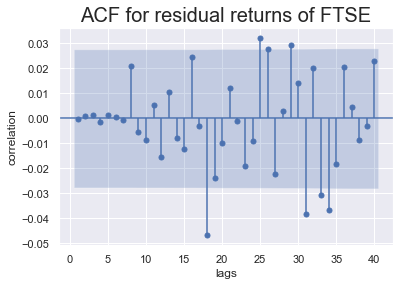

In [55]:
# no significant auto correlation for until 17 lags, this mean that our model_7 is a good predictor
# The other significant coefficient after 18 lags shows the market's adjustment
# similar to the residual price's result
sgt.plot_acf(df.res_return, zero=False, lags=40)
plt.title('ACF for residual returns of FTSE', size=20)
plt.xlabel('lags')
plt.ylabel('correlation')

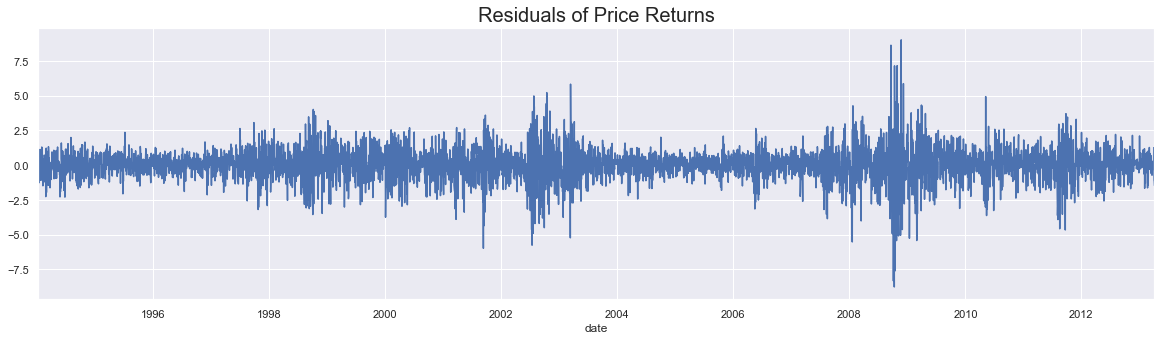

In [53]:
# similar to the price's residual result
df.res_return.plot(figsize=(20,5))
plt.title('Residuals of Price Returns', size=20)
plt.show()

In [54]:
df

,market_value,Returns,norm,norm_re,re2,res_return
date,,,,,,
1994-01-10,3440.58,-0.156704,100.000000,100.000000,NaN,-0.175618
1994-01-11,3413.77,-0.779229,99.220771,497.260711,-0.779229,-0.802193
1994-01-12,3372.02,-1.222988,98.007313,780.443046,-1.222988,-1.270024
1994-01-13,3360.01,-0.356166,97.658244,227.285567,-0.356166,-0.466062
1994-01-14,3400.56,1.206842,98.836824,-770.139292,1.206842,1.061277
...,...,...,...,...,...,...
2013-04-01,6411.74,0.000000,186.356370,-0.000000,0.000000,-0.036820
2013-04-02,6490.66,1.230867,188.650169,-785.471020,1.230867,1.257627
2013-04-03,6420.28,-1.084327,186.604584,691.957459,-1.084327,-1.087559
